## Statistical Analysis for Laparoscopic Cholecystectomy Workflow
### Analyzes ICU admission and ASA classification effects on surgery duration

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal
import itertools
import matplotlib.pyplot as plt

In [2]:
# Configuration
OCEL_FILE = 'results/mover_OCEL.jsonocel'  # Update path as needed
RANDOM_SEED = 42
N_BOOTSTRAP = 10000
BONFERRONI_ALPHA = 0.05

print("Loading OCEL data...")

with open(OCEL_FILE, 'r') as f:
    ocel_data = json.load(f)

print(f"✓ Loaded {len(ocel_data['ocel:events'])} events")
print(f"✓ Loaded {len(ocel_data['ocel:objects'])} objects")

Loading OCEL data...
✓ Loaded 9350 events
✓ Loaded 2310 objects


In [3]:
# Extract surgery information
print("Extracting surgery-level data...")
surgeries = {}
for obj_id, obj_data in ocel_data['ocel:objects'].items():
    if obj_data['ocel:type'] == 'surgery':
        ovmap = obj_data.get('ocel:ovmap', {})
        surgeries[obj_id] = {
            'icu_admission': 1 if ovmap.get('admitted ICU') == 'Yes' else 0
        }

print(f"✓ Found {len(surgeries)} surgeries")

Extracting surgery-level data...
✓ Found 1186 surgeries


In [4]:
# Map rating descriptions to ASA levels
asa_mapping = {
    'r_Healthy': 'I',
    'r_Mild Systemic Disease': 'II',
    'r_Severe Systemic Disease': 'III',
    'r_Incapacitating Disease': 'IV'
}

# Process events to link surgeries with ratings and calculate durations
print("Processing events and calculating durations...")
events_df = pd.DataFrame(ocel_data['ocel:events'].values())

surgery_data = []
for surgery_id, surgery_info in surgeries.items():
    # Find events for this surgery
    surgery_events = events_df[events_df['ocel:omap'].apply(lambda x: surgery_id in x)]
    
    if len(surgery_events) == 0:
        continue
    
    # Find linked ASA rating
    rating_id = None
    for omap in surgery_events['ocel:omap']:
        for oid in omap:
            if oid in asa_mapping:
                rating_id = oid
                break
        if rating_id:
            break
    
    asa_level = asa_mapping.get(rating_id) if rating_id else None
    
    # Calculate total duration (first event to last event)
    surgery_timestamps = pd.to_datetime(surgery_events['ocel:timestamp'])
    duration_hours = (surgery_timestamps.max() - surgery_timestamps.min()).total_seconds() / 3600
    
    surgery_data.append({
        'surgery_id': surgery_id,
        'icu_admission': surgery_info['icu_admission'],
        'asa_level': asa_level,
        'duration_hours': duration_hours
    })

df = pd.DataFrame(surgery_data)
df = df[df['duration_hours'] > 0]  # Remove zero-duration cases
df = df.dropna(subset=['asa_level'])  # Remove cases without ASA rating

print(f"✓ Analysis dataset: {len(df)} surgeries with complete data")
print(f"  - Non-ICU: {(df['icu_admission']==0).sum()}")
print(f"  - ICU: {(df['icu_admission']==1).sum()}")
print(f"  - ASA I: {(df['asa_level']=='I').sum()}")
print(f"  - ASA II: {(df['asa_level']=='II').sum()}")
print(f"  - ASA III: {(df['asa_level']=='III').sum()}")
print(f"  - ASA IV: {(df['asa_level']=='IV').sum()}")

Processing events and calculating durations...
✓ Analysis dataset: 1118 surgeries with complete data
  - Non-ICU: 765
  - ICU: 353
  - ASA I: 74
  - ASA II: 606
  - ASA III: 422
  - ASA IV: 16


## ANALYSIS: ICU Admission Effect

In [5]:
icu_no = df[df['icu_admission'] == 0]['duration_hours']
icu_yes = df[df['icu_admission'] == 1]['duration_hours']

# Descriptive statistics
print(f"\nDescriptive Statistics:")

print(f"\nICU YES (n={len(icu_yes)}):")
print(f"  Median: {icu_yes.median():.2f} hours")
print(f"  IQR: {icu_yes.quantile(0.25):.2f} - {icu_yes.quantile(0.75):.2f} hours")
print(f"  Mean ± SD: {icu_yes.mean():.2f} ± {icu_yes.std():.2f} hours")
print(f"  Range: {icu_yes.min():.2f} - {icu_yes.max():.2f} hours")

print(f"\nICU NO (n={len(icu_no)}):")
print(f"  Median: {icu_no.median():.2f} hours")
print(f"  IQR: {icu_no.quantile(0.25):.2f} - {icu_no.quantile(0.75):.2f} hours")
print(f"  Mean ± SD: {icu_no.mean():.2f} ± {icu_no.std():.2f} hours")
print(f"  Range: {icu_no.min():.2f} - {icu_no.max():.2f} hours")


Descriptive Statistics:

ICU YES (n=353):
  Median: 13.83 hours
  IQR: 10.52 - 16.98 hours
  Mean ± SD: 13.77 ± 4.51 hours
  Range: 3.73 - 25.60 hours

ICU NO (n=765):
  Median: 8.85 hours
  IQR: 4.72 - 14.03 hours
  Mean ± SD: 9.63 ± 5.35 hours
  Range: 2.48 - 25.13 hours


### ICU Mann-Whitney U test

In [6]:
icu_mannwhitneyu_stat, icu_mannwhitneyu_p_value = mannwhitneyu(icu_yes, icu_no, alternative='two-sided')
print(f"ICU Mann-Whitney U Test:")
print(f"  U-statistic: {icu_mannwhitneyu_stat:.1f}")
print(f"  p-value: {icu_mannwhitneyu_p_value:.6f}")
if icu_mannwhitneyu_p_value < 0.001:
    icu_mannwhitneyu_significant = '***'
    print(f"  Mann-Whitney U Significance: p < 0.001 ***")
elif icu_mannwhitneyu_p_value < 0.01:
    icu_mannwhitneyu_significant = '**'
    print(f"  Mann-Whitney U Significance: p < 0.01 **")
elif icu_mannwhitneyu_p_value < 0.05:
    icu_mannwhitneyu_significant = '*'
    print(f"  Mann-Whitney U Significance: p < 0.05 *")
else:
    icu_mannwhitneyu_significant = 'ns'
    print(f"  Mann-Whitney U Significance: Not significant (p ≥ 0.05)")

ICU Mann-Whitney U Test:
  U-statistic: 194735.0
  p-value: 0.000000
  Mann-Whitney U Significance: p < 0.001 ***


### ICU Effect size (Cohen's d)

In [7]:
icu_pooled_std = np.sqrt(((len(icu_no)-1)*icu_no.std()**2 + (len(icu_yes)-1)*icu_yes.std()**2) / (len(icu_no) + len(icu_yes) - 2))
icu_cohens_d = (icu_yes.mean() - icu_no.mean()) / icu_pooled_std
icu_effect_interpretation = 'large' if abs(icu_cohens_d) >= 0.8 else 'medium' if abs(icu_cohens_d) >= 0.5 else 'small'
print(f"ICU Effect Size:")
print(f"  Cohen's d: {icu_cohens_d:.3f} ({icu_effect_interpretation} effect)")

ICU Effect Size:
  Cohen's d: 0.813 (large effect)


### ICU Bootstrap 95% Confidence Interval

In [8]:
# 95% Confidence Interval for median difference using bootstrap
print(f"ICU Bootstrap 95% Confidence Interval (n={N_BOOTSTRAP} iterations):")
np.random.seed(RANDOM_SEED)
icu_bootstrap_median_diffs = []
for _ in range(N_BOOTSTRAP):
    icu_yes_sample = np.random.choice(icu_yes, size=len(icu_yes), replace=True)
    icu_no_sample = np.random.choice(icu_no, size=len(icu_no), replace=True)
    icu_bootstrap_median_diffs.append(np.median(icu_yes_sample) - np.median(icu_no_sample))

icu_bootstrap_ci_lower = np.percentile(icu_bootstrap_median_diffs, 2.5)
icu_bootstrap_ci_upper = np.percentile(icu_bootstrap_median_diffs, 97.5)
icu_bootstrap_observed_diff = icu_yes.median() - icu_no.median()
print(f"  Observed median difference: {icu_bootstrap_observed_diff:.2f} hours")
print(f"  95% CI: [{icu_bootstrap_ci_lower:.2f}, {icu_bootstrap_ci_upper:.2f}] hours")

ICU Bootstrap 95% Confidence Interval (n=10000 iterations):
  Observed median difference: 4.98 hours
  95% CI: [3.88, 6.77] hours


### ICU Kruskal-Wallis H test

In [9]:
icu_kruskal_h_stat, icu_kruskal_p_value = kruskal(icu_yes, icu_no)
print(f"ICU Kruskal-Wallis H Test:")
print(f"  H-statistic: {icu_kruskal_h_stat:.3f}")
print(f"  Degrees of freedom: 3")
print(f"  p-value: {icu_kruskal_p_value:.6f}")
if icu_kruskal_p_value < 0.001:
    icu_kruskal_significant = '***'
    print(f"  Significance: p < 0.001 ***")
elif icu_kruskal_p_value < 0.01:
    icu_kruskal_significant = '**'
    print(f"  Significance: p < 0.01 **")
elif icu_kruskal_p_value < 0.05:
    icu_kruskal_significant = '*'
    print(f"  Significance: p < 0.05 *")
else:
    icu_kruskal_significant = 'ns'
    print(f"  Significance: Not significant (p ≥ 0.05)")

ICU Kruskal-Wallis H Test:
  H-statistic: 141.595
  Degrees of freedom: 3
  p-value: 0.000000
  Significance: p < 0.001 ***


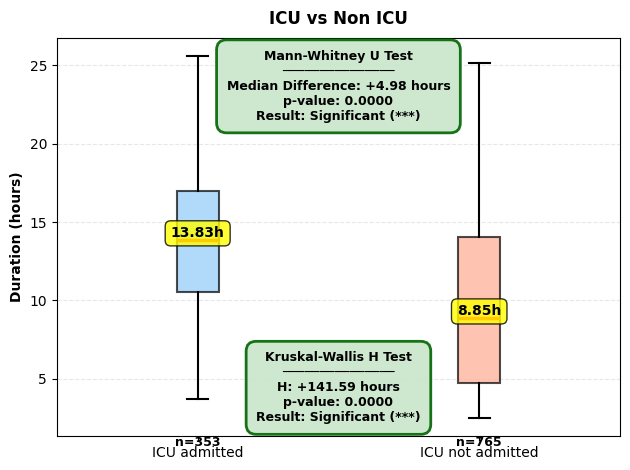

In [10]:
fig, ax = plt.subplots()

# Create boxplot
box_data = [icu_yes, icu_no]
bp = ax.boxplot(box_data, 
                tick_labels=[f'ICU admitted', f'ICU not admitted'],
                showfliers=True,
                patch_artist=True,
                boxprops=dict(linewidth=1.5),
                medianprops=dict(color='red', linewidth=2.5),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='gray', 
                                markersize=4, alpha=0.5))
# Color the boxes differently
colors = ['#90CAF9', '#FFAB91']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add median values on boxes
icu_yes_median = icu_yes.median()
icu_no_median = icu_no.median()
icu_median_diff = icu_yes_median - icu_no_median

ax.text(1, icu_yes_median, f'{icu_yes_median:.2f}h', 
        ha='center', va='bottom', fontweight='bold', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8))

ax.text(2, icu_no_median, f'{icu_no_median:.2f}h', 
        ha='center', va='bottom', fontweight='bold', fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8))

# Add sample sizes
ax.text(1, ax.get_ylim()[0], f'n={len(icu_yes)}', 
        ha='center', va='top', fontsize=9, fontweight='bold')
ax.text(2, ax.get_ylim()[0], f'n={len(icu_no)}', 
        ha='center', va='top', fontsize=9, fontweight='bold')

# Determine background color based on Mann-Whitney U Test significance
if icu_mannwhitneyu_significant != 'ns':
    bgcolor = '#C8E6C9'  # Light green
    text_color = 'darkgreen'
    mannwhitneyu_result_text = f'Significant ({icu_mannwhitneyu_significant})'
else:
    bgcolor = '#FFCDD2'  # Light red
    text_color = 'darkred'
    mannwhitneyu_result_text = 'Not Significant'

# Create Mann-Whitney U Test statistics text
mannwhitneyu_stats_text = (f'Mann-Whitney U Test\n'
                f'───────────────\n'
                f'Median Difference: {icu_median_diff:+.2f} hours\n'
                f'p-value: {icu_mannwhitneyu_p_value:.4f}\n'
                f'Result: {mannwhitneyu_result_text}')

# Add text box with Mann-Whitney U Test results 
ax.text(0.5, 0.97, mannwhitneyu_stats_text,
        transform=ax.transAxes,
        ha='center', 
        va='top',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', 
                    facecolor=bgcolor, 
                    edgecolor=text_color,
                    linewidth=2,
                    alpha=0.9))


# Determine background color based on Kruskal-Wallis H Test significance
if icu_kruskal_significant != 'ns':
    bgcolor = '#C8E6C9'  # Light green
    text_color = 'darkgreen'
    kruskal_result_text = f'Significant ({icu_mannwhitneyu_significant})'
else:
    bgcolor = '#FFCDD2'  # Light red
    text_color = 'darkred'
    kruskal_result_text = 'Not Significant'

# Create Kruskal-Wallis H Test statistics text
kruskal_stats_text = (f'Kruskal-Wallis H Test\n'
                f'───────────────\n'
                f'H: {icu_kruskal_h_stat:+.2f} hours\n'
                f'p-value: {icu_kruskal_p_value:.4f}\n'
                f'Result: {kruskal_result_text}')

# Add text box with Kruskal-Wallis H Test results
ax.text(0.5, 0.03, kruskal_stats_text,
        transform=ax.transAxes,
        ha='center', 
        va='bottom',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', 
                    facecolor=bgcolor, 
                    edgecolor=text_color,
                    linewidth=2,
                    alpha=0.9))

# Formatting
ax.set_ylabel('Duration (hours)', fontsize=10, fontweight='bold')
ax.set_title(f'ICU vs Non ICU', fontsize=12, fontweight='bold', pad=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('results/figure_1.png', dpi=300, bbox_inches='tight')
plt.show()

## ANALYSIS: ASA Classification Effect

In [11]:
# Descriptive statistics by ASA level
print(f"Descriptive Statistics by ASA Level:")
for asa in ['I', 'II', 'III', 'IV']:
    asa_data = df[df['asa_level'] == asa]['duration_hours']
    print(f"\nASA {asa} (n={len(asa_data)}):")
    print(f"  Median: {asa_data.median():.2f} hours")
    print(f"  IQR: {asa_data.quantile(0.25):.2f} - {asa_data.quantile(0.75):.2f} hours")
    print(f"  Mean ± SD: {asa_data.mean():.2f} ± {asa_data.std():.2f} hours")
    print(f"  Range: {asa_data.min():.2f} - {asa_data.max():.2f} hours")

Descriptive Statistics by ASA Level:

ASA I (n=74):
  Median: 11.46 hours
  IQR: 5.42 - 14.91 hours
  Mean ± SD: 10.98 ± 5.42 hours
  Range: 2.73 - 23.97 hours

ASA II (n=606):
  Median: 10.75 hours
  IQR: 5.07 - 15.50 hours
  Mean ± SD: 10.83 ± 5.51 hours
  Range: 2.48 - 25.13 hours

ASA III (n=422):
  Median: 10.80 hours
  IQR: 5.80 - 15.29 hours
  Mean ± SD: 11.11 ± 5.37 hours
  Range: 2.93 - 25.60 hours

ASA IV (n=16):
  Median: 9.64 hours
  IQR: 6.33 - 14.72 hours
  Mean ± SD: 10.51 ± 5.43 hours
  Range: 3.58 - 22.72 hours


### ASA Kruskal-Wallis H test

In [12]:
asa_groups = [df[df['asa_level'] == asa]['duration_hours'].values for asa in ['I', 'II', 'III', 'IV']]
asa_kruskal_h_stat, asa_kruskal_p_value = kruskal(*asa_groups)

print(f"ASA Kruskal-Wallis H Test:")
print(f"  H-statistic: {asa_kruskal_h_stat:.3f}")
print(f"  Degrees of freedom: 3")
print(f"  p-value: {asa_kruskal_p_value:.6f}")
if asa_kruskal_p_value < 0.001:
    asa_kruskal_significant = '***'
    print(f"  Significance: p < 0.001 ***")
elif asa_kruskal_p_value < 0.01:
    asa_kruskal_significant = '**'
    print(f"  Significance: p < 0.01 **")
elif asa_kruskal_p_value < 0.05:
    asa_kruskal_significant = '*'
    print(f"  Significance: p < 0.05 *")
else:
    asa_kruskal_significant = 'ns'
    print(f"  Significance: Not significant (p ≥ 0.05)")

ASA Kruskal-Wallis H Test:
  H-statistic: 0.906
  Degrees of freedom: 3
  p-value: 0.824064
  Significance: Not significant (p ≥ 0.05)


### ASA Effect size (eta-squared)

In [13]:
n_total = len(df)
asa_k_groups = 4
asa_eta_squared = (icu_kruskal_h_stat - asa_k_groups + 1) / (n_total - asa_k_groups)
print(f"ASA Effect Size (eta-squared):")
print(f"  η² (eta-squared): {asa_eta_squared:.4f}")

ASA Effect Size (eta-squared):
  η² (eta-squared): 0.1244


### ASA Post-hoc pairwise comparisons with Bonferroni correction

In [14]:
asa_levels = ['I', 'II', 'III', 'IV']
asa_n_comparisons = len(list(itertools.combinations(asa_levels, 2)))
asa_bonferroni_alpha = BONFERRONI_ALPHA / asa_n_comparisons

print(f"\nPost-hoc Pairwise Comparisons:")
print(f"  Number of comparisons: {asa_n_comparisons}")
print(f"  Bonferroni-corrected α: {asa_bonferroni_alpha:.4f}")
print()


Post-hoc Pairwise Comparisons:
  Number of comparisons: 6
  Bonferroni-corrected α: 0.0083



In [15]:
asa_pairwise_results = []
for asa1, asa2 in itertools.combinations(asa_levels, 2):
    group1 = df[df['asa_level'] == asa1]['duration_hours']
    group2 = df[df['asa_level'] == asa2]['duration_hours']
    
    asa_mannwhitneyu_stat, asa_mannwhitneyu_p_val = mannwhitneyu(group1, group2, alternative='two-sided')
    asa_median_diff = group2.median() - group1.median()
    
    # Determine significance marker
    if asa_mannwhitneyu_p_val < 0.001:
        asa_mannwhitneyu_significant = '***'
    elif asa_mannwhitneyu_p_val < 0.01:
        asa_mannwhitneyu_significant = '**'
    elif asa_mannwhitneyu_p_val < asa_bonferroni_alpha:
        asa_mannwhitneyu_significant = '*'
    else:
        asa_mannwhitneyu_significant = 'ns'
    
    print(f"  ASA {asa1} vs ASA {asa2}:")
    print(f"    n1={len(group1)}, n2={len(group2)}")
    print(f"    Median difference: {asa_median_diff:+.2f} hours")
    print(f"    U-statistic: {asa_mannwhitneyu_stat:.1f}")
    print(f"    p-value: {asa_mannwhitneyu_p_val:.6f} {asa_mannwhitneyu_significant}")
    print()
    
    asa_pairwise_results.append({
        'Comparison': f'ASA {asa1} vs {asa2}',
        'Median_Diff': icu_median_diff,
        'p_value': asa_mannwhitneyu_p_val,
        'U-statistic': asa_mannwhitneyu_stat,
        'Significant': asa_mannwhitneyu_significant
    })

  ASA I vs ASA II:
    n1=74, n2=606
    Median difference: -0.71 hours
    U-statistic: 22607.5
    p-value: 0.907678 ns

  ASA I vs ASA III:
    n1=74, n2=422
    Median difference: -0.66 hours
    U-statistic: 15387.5
    p-value: 0.842479 ns

  ASA I vs ASA IV:
    n1=74, n2=16
    Median difference: -1.82 hours
    U-statistic: 613.5
    p-value: 0.824604 ns

  ASA II vs ASA III:
    n1=606, n2=422
    Median difference: +0.05 hours
    U-statistic: 123509.5
    p-value: 0.352264 ns

  ASA II vs ASA IV:
    n1=606, n2=16
    Median difference: -1.11 hours
    U-statistic: 4952.5
    p-value: 0.883461 ns

  ASA III vs ASA IV:
    n1=422, n2=16
    Median difference: -1.16 hours
    U-statistic: 3592.5
    p-value: 0.663847 ns



In [16]:
asa_comparison = pd.DataFrame(asa_pairwise_results)
asa_comparison

,Comparison,Median_Diff,p_value,U-statistic,Significant
0,ASA I vs II,4.983333,0.907678,22607.5,ns
1,ASA I vs III,4.983333,0.842479,15387.5,ns
2,ASA I vs IV,4.983333,0.824604,613.5,ns
3,ASA II vs III,4.983333,0.352264,123509.5,ns
4,ASA II vs IV,4.983333,0.883461,4952.5,ns
5,ASA III vs IV,4.983333,0.663847,3592.5,ns


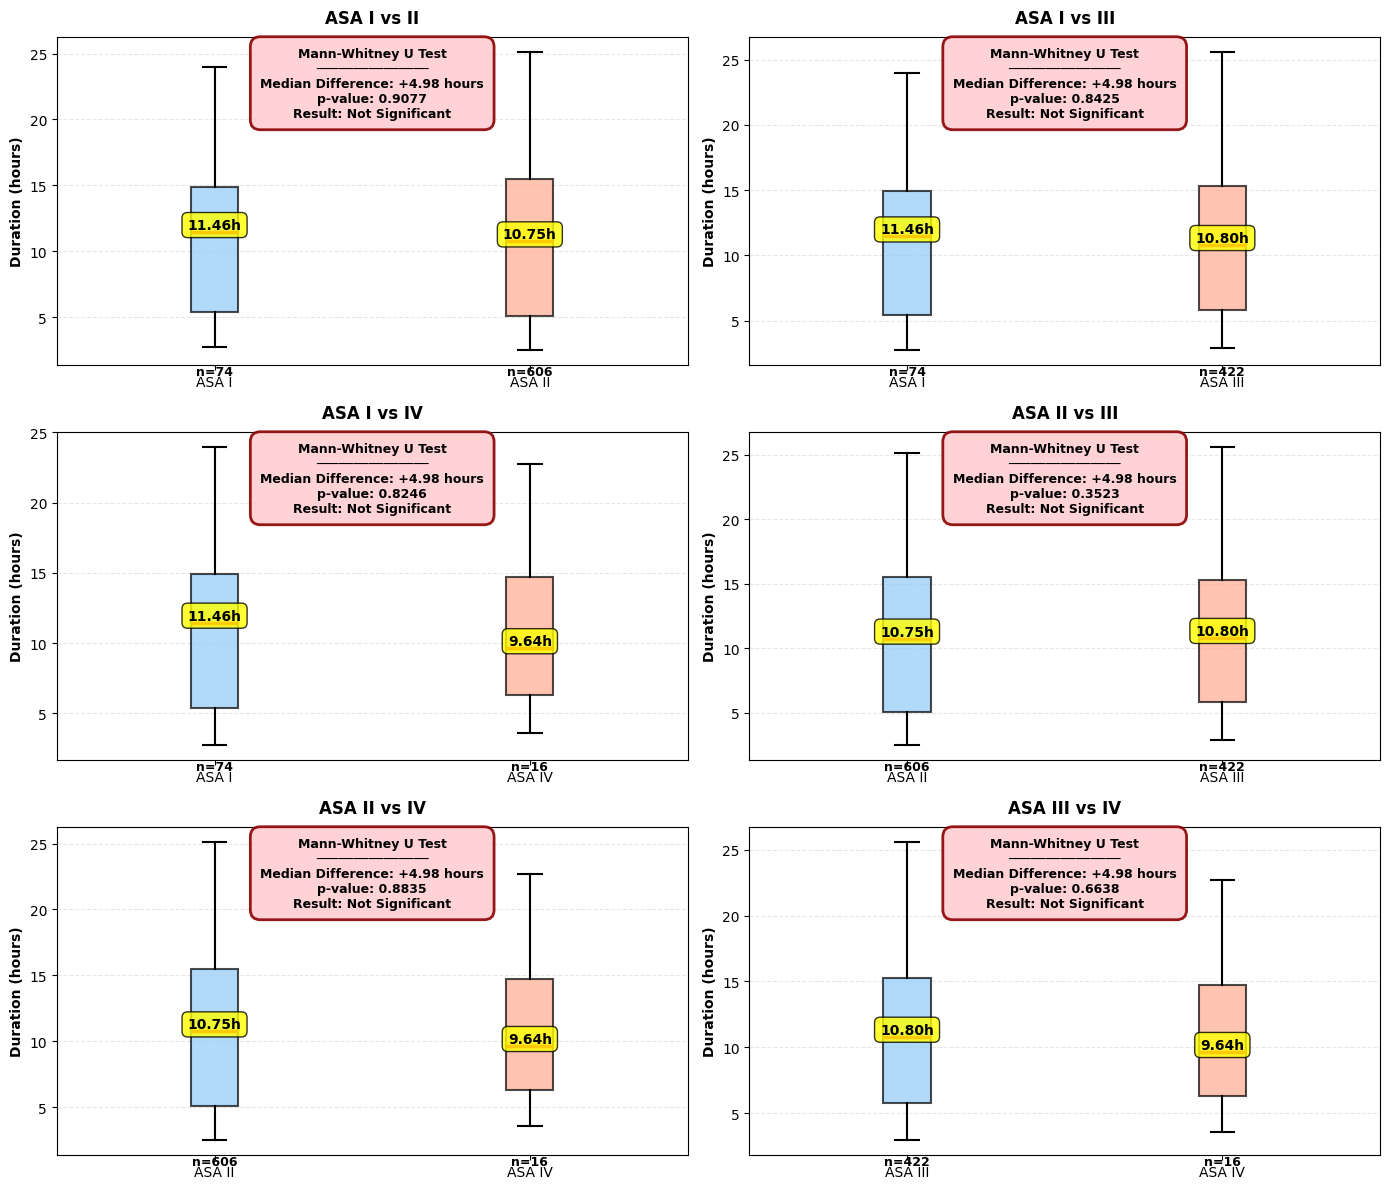

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# Create each pairwise comparison plot
for idx, result in enumerate(asa_pairwise_results):
    ax = axes[idx]
    
    # Parse comparison - handle Roman numerals
    comp = result['Comparison']
    parts = comp.split('vs')
    asa1 = parts[0].replace('ASA', '').strip()
    asa2 = parts[1].replace('ASA', '').strip()
    
    # Get data for both groups
    group1 = df[df['asa_level'] == asa1]['duration_hours']
    group2 = df[df['asa_level'] == asa2]['duration_hours']
    
    # Create boxplot
    box_data = [group1, group2]
    bp = ax.boxplot(box_data, 
                    tick_labels=[f'ASA {asa1}', f'ASA {asa2}'],
                    patch_artist=True,
                    boxprops=dict(linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='gray', 
                                   markersize=4, alpha=0.5))
    
    # Color the boxes differently
    colors = ['#90CAF9', '#FFAB91']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add median values on boxes
    icu_yes_median = group1.median()
    icu_no_median = group2.median()
    
    ax.text(1, icu_yes_median, f'{icu_yes_median:.2f}h', 
            ha='center', va='bottom', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8))
    
    ax.text(2, icu_no_median, f'{icu_no_median:.2f}h', 
            ha='center', va='bottom', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8))
    
    # Add sample sizes
    ax.text(1, ax.get_ylim()[0], f'n={len(group1)}', 
            ha='center', va='top', fontsize=9, fontweight='bold')
    ax.text(2, ax.get_ylim()[0], f'n={len(group2)}', 
            ha='center', va='top', fontsize=9, fontweight='bold')
    
    # Add statistical results as text box
    asa_median_diff = result['Median_Diff']
    asa_p_val = result['p_value']
    asa_sig = result['Significant']
    
    # Determine background color based on significance
    if asa_sig != 'ns':
        bgcolor = '#C8E6C9'  # Light green
        text_color = 'darkgreen'
        mannwhitneyu_result_text = f'Significant ({asa_sig})'
    else:
        bgcolor = '#FFCDD2'  # Light red
        text_color = 'darkred'
        mannwhitneyu_result_text = 'Not Significant'
    
    # Create statistics text
    mannwhitneyu_stats_text = (f'Mann-Whitney U Test\n'
                  f'───────────────\n'
                  f'Median Difference: {asa_median_diff:+.2f} hours\n'
                  f'p-value: {asa_p_val:.4f}\n'
                  f'Result: {mannwhitneyu_result_text}')
    
    # Add text box with results
    ax.text(0.5, 0.97, mannwhitneyu_stats_text,
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.8', 
                     facecolor=bgcolor, 
                     edgecolor=text_color,
                     linewidth=2,
                     alpha=0.9))
    
    # Formatting
    ax.set_ylabel('Duration (hours)', fontsize=10, fontweight='bold')
    ax.set_title(f'{comp}', fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('results/figure_2.png', dpi=300, bbox_inches='tight')
plt.show()

## SUMMARY

In [18]:
print(f"""
ICU Admission Effect:
--------------------
ICU-admitted patients (n={len(icu_yes)}) demonstrated significantly longer 
perioperative durations compared to non-ICU patients (n={len(icu_no)}):
  - Non-ICU median: {icu_no.median():.2f} hours (IQR: {icu_no.quantile(0.25):.2f}-{icu_no.quantile(0.75):.2f})
  - ICU median: {icu_yes.median():.2f} hours (IQR: {icu_yes.quantile(0.25):.2f}-{icu_yes.quantile(0.75):.2f})
  - Mann-Whitney U = {icu_mannwhitneyu_stat:.0f}, p < 0.001
  - Median difference: {icu_bootstrap_observed_diff:.2f} hours (95% CI: [{icu_bootstrap_ci_lower:.2f}, {icu_bootstrap_ci_upper:.2f}])
  - Cohen's d = {icu_cohens_d:.2f} (large effect)

ASA Classification Effect:
-------------------------
ASA classification showed no statistically significant effect on 
perioperative duration:
  - Kruskal-Wallis H = {icu_kruskal_h_stat:.2f}, df = 3, p = {icu_kruskal_p_value:.3f}
  - η² = {asa_eta_squared:.4f}
  - No pairwise comparisons significant after Bonferroni correction (α = {asa_bonferroni_alpha:.4f})

Interpretation:
--------------
The lack of ASA effect on total perioperative time likely reflects that ASA 
classification primarily predicts intraoperative anesthetic risk rather than 
total process duration, which is more influenced by postoperative care 
disposition (ICU vs floor admission).
""")


ICU Admission Effect:
--------------------
ICU-admitted patients (n=353) demonstrated significantly longer 
perioperative durations compared to non-ICU patients (n=765):
  - Non-ICU median: 8.85 hours (IQR: 4.72-14.03)
  - ICU median: 13.83 hours (IQR: 10.52-16.98)
  - Mann-Whitney U = 194735, p < 0.001
  - Median difference: 4.98 hours (95% CI: [3.88, 6.77])
  - Cohen's d = 0.81 (large effect)

ASA Classification Effect:
-------------------------
ASA classification showed no statistically significant effect on 
perioperative duration:
  - Kruskal-Wallis H = 141.59, df = 3, p = 0.000
  - η² = 0.1244
  - No pairwise comparisons significant after Bonferroni correction (α = 0.0083)

Interpretation:
--------------
The lack of ASA effect on total perioperative time likely reflects that ASA 
classification primarily predicts intraoperative anesthetic risk rather than 
total process duration, which is more influenced by postoperative care 
disposition (ICU vs floor admission).

